# Feature Points Detection

## Load Dataset

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import os

%matplotlib inline

In [2]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_COLOR)
        if img is not None:
            images.append(img)
    return images

In [3]:
images_path = '../data/datasets/milkbox_dataset/images'
images = load_images_from_folder(images_path)
sample_size = 4

images_count = len(images)
random_indexes = random.sample(range(images_count), sample_size if images_count > sample_size else images_count)
print('Taken {} from {} images'.format(random_indexes, images_count))

sample_images = []
gray_images = []

for i in range(sample_size):
    sample_images.append(images[i])
    gray_image = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)
    gray_images.append(gray_image)

Taken [11, 12, 14, 42] from 43 images


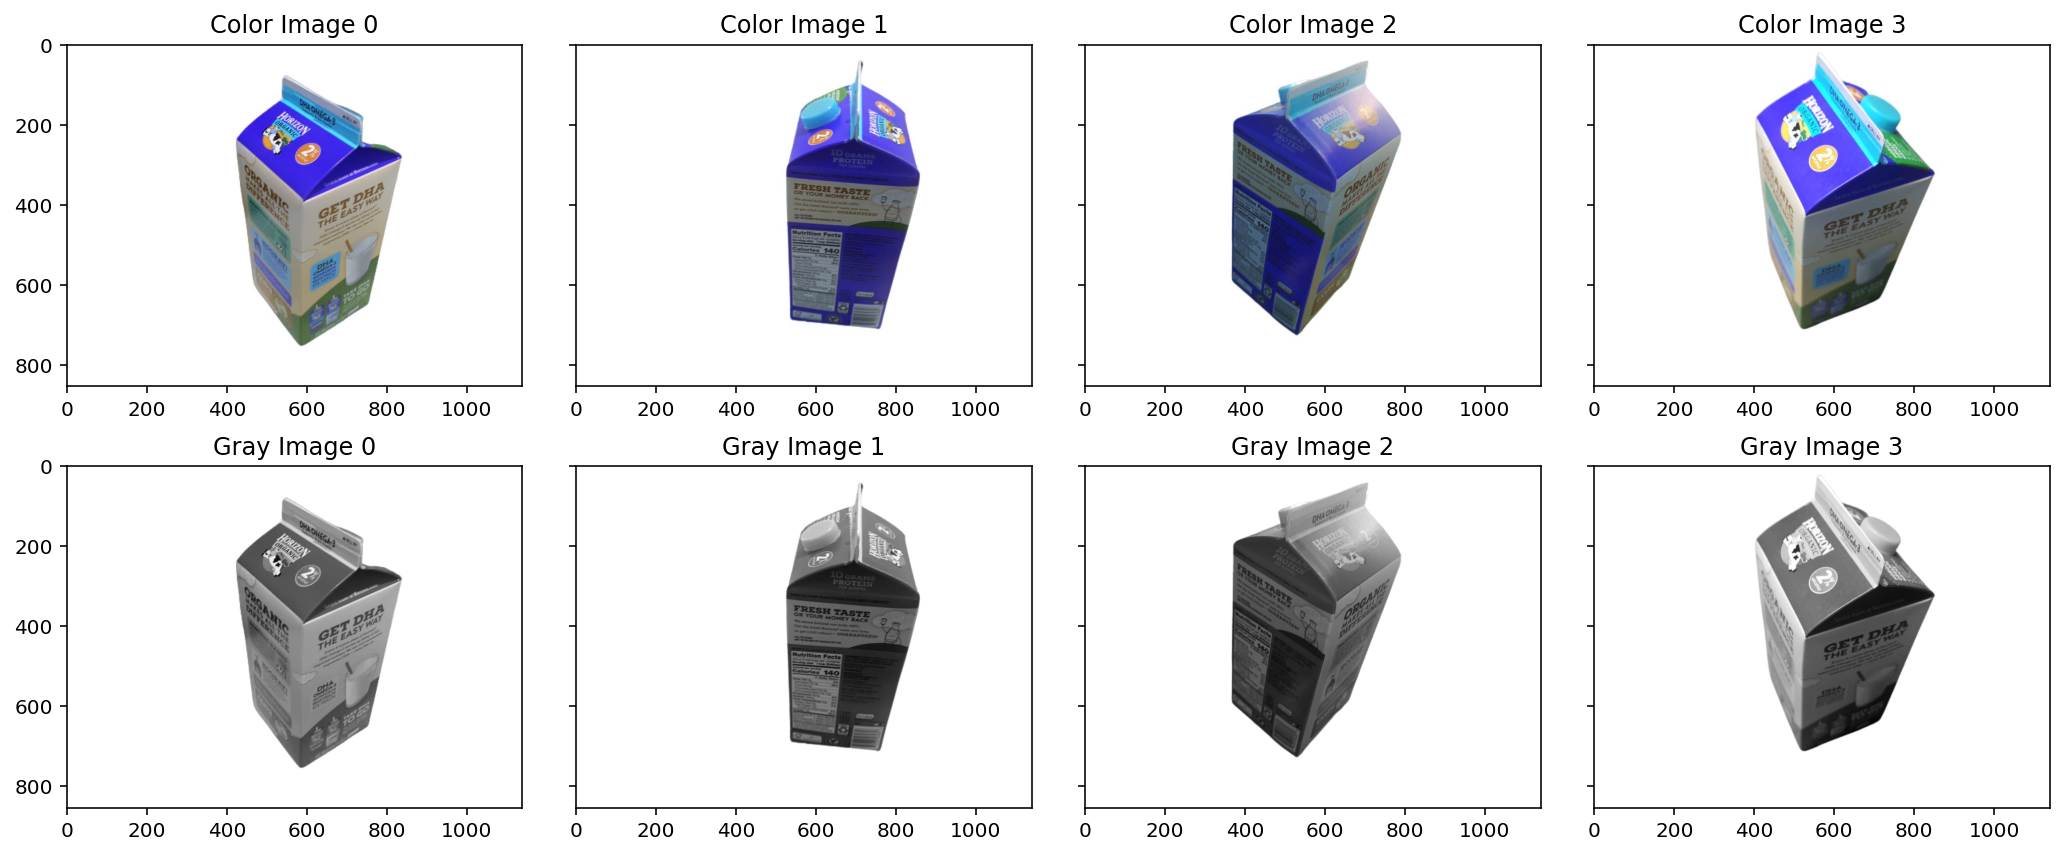

In [4]:
def display_samples(images):
    fig, ax = plt.subplots(2, len(images), figsize=(14.5, 6), constrained_layout=True, sharey=True)
    fig.set_dpi(144)
    fig.tight_layout()

    for i in range(len(images)):
        ax[0, i].set_title('Color Image {}'.format(i))
        ax[0, i].imshow(images[i])
        ax[1, i].set_title('Gray Image {}'.format(i))
        ax[1, i].imshow(gray_images[i], cmap='gray')

display_samples(sample_images)

## Feature Matching


### SIFT Algorithm

#### Detect Feature Points

In [5]:
sift = cv2.SIFT_create()

feature_points_list = []
descriptors_list = []

for gray_image in gray_images:
    kps, des = sift.detectAndCompute(gray_image, None)
    feature_points_list.append(kps)
    descriptors_list.append(des)

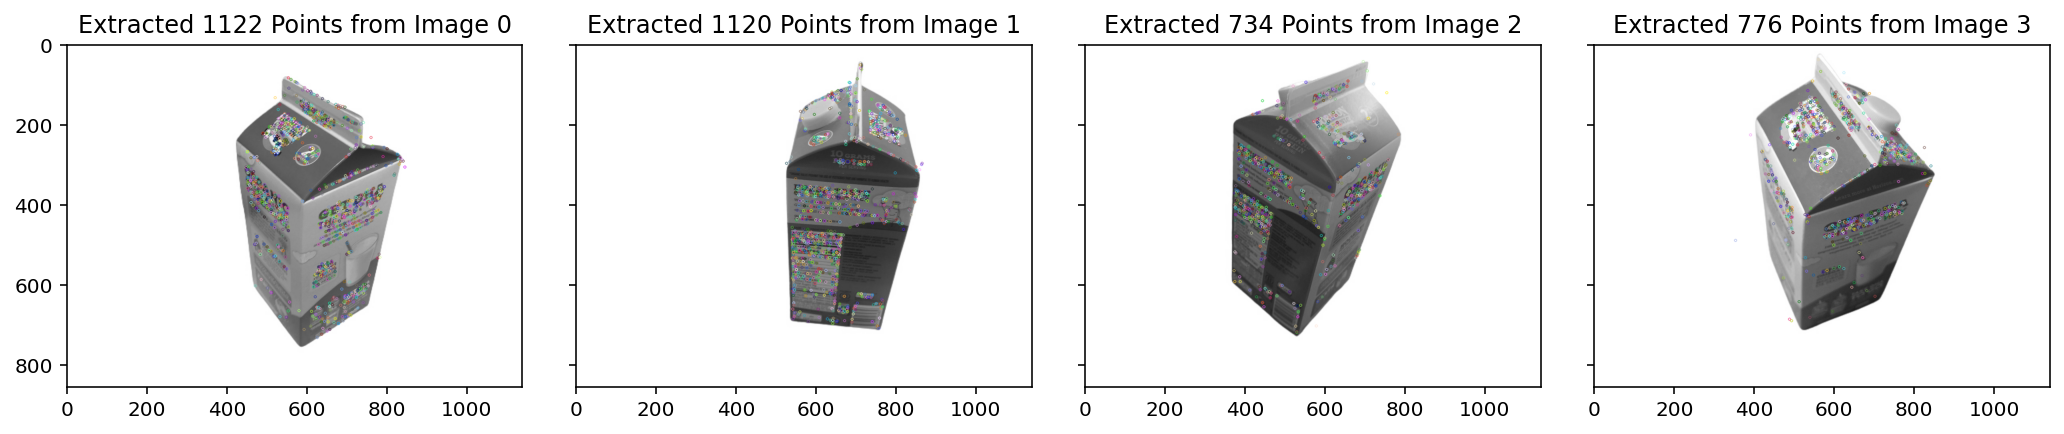

In [6]:
def display_feature_points(images, points):
    fig, ax = plt.subplots(1, len(images), figsize=(14.5, 4), constrained_layout=True, sharey=True)
    fig.set_dpi(144)
    fig.tight_layout()

    for i in range(len(images)):
        ax[i].set_title('Extracted {} Points from Image {}'.format(len(feature_points_list[i]), i))
        image_with_points = cv2.drawKeypoints(images[i], points[i], None)
        ax[i].imshow(image_with_points)

display_feature_points(gray_images, feature_points_list)

#### Matching Feature Points using FLANN

In [7]:
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

matcher = cv2.FlannBasedMatcher(index_params, search_params)
matches = matcher.knnMatch(descriptors_list[0], descriptors_list[1], k=2)

In [8]:
# ratio test as per Lowe's paper
ratio_thresh = 0.8
good_matches = []

for m, n in matches:
    if m.distance < ratio_thresh * n.distance:
        good_matches.append(m)

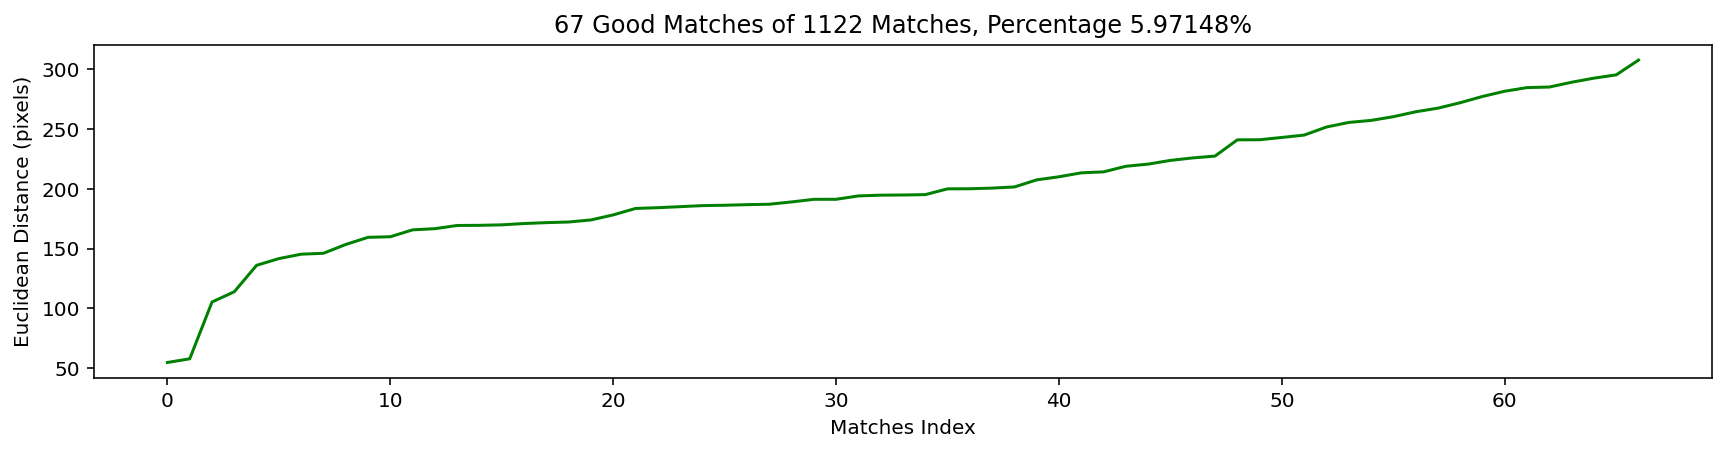

In [9]:
def display_matches_quality(good_matches, all_matches):
    good_matches_sorted = sorted(good_matches, key=lambda val: val.distance)
    distances = [m.distance for m in good_matches_sorted]
    percentage = len(good_matches) / len(all_matches)

    x = np.arange(0, len(distances))
    y = distances
    
    plt.figure(figsize=(14.5, 3), dpi=144)
    plt.title('{} Good Matches of {} Matches, Percentage {:.5f}%'.format(len(good_matches), len(all_matches), percentage * 100))
    plt.xlabel('Matches Index')
    plt.ylabel('Euclidean Distance (pixels)')
    plt.plot(x, y, color='green')

display_matches_quality(good_matches, matches)


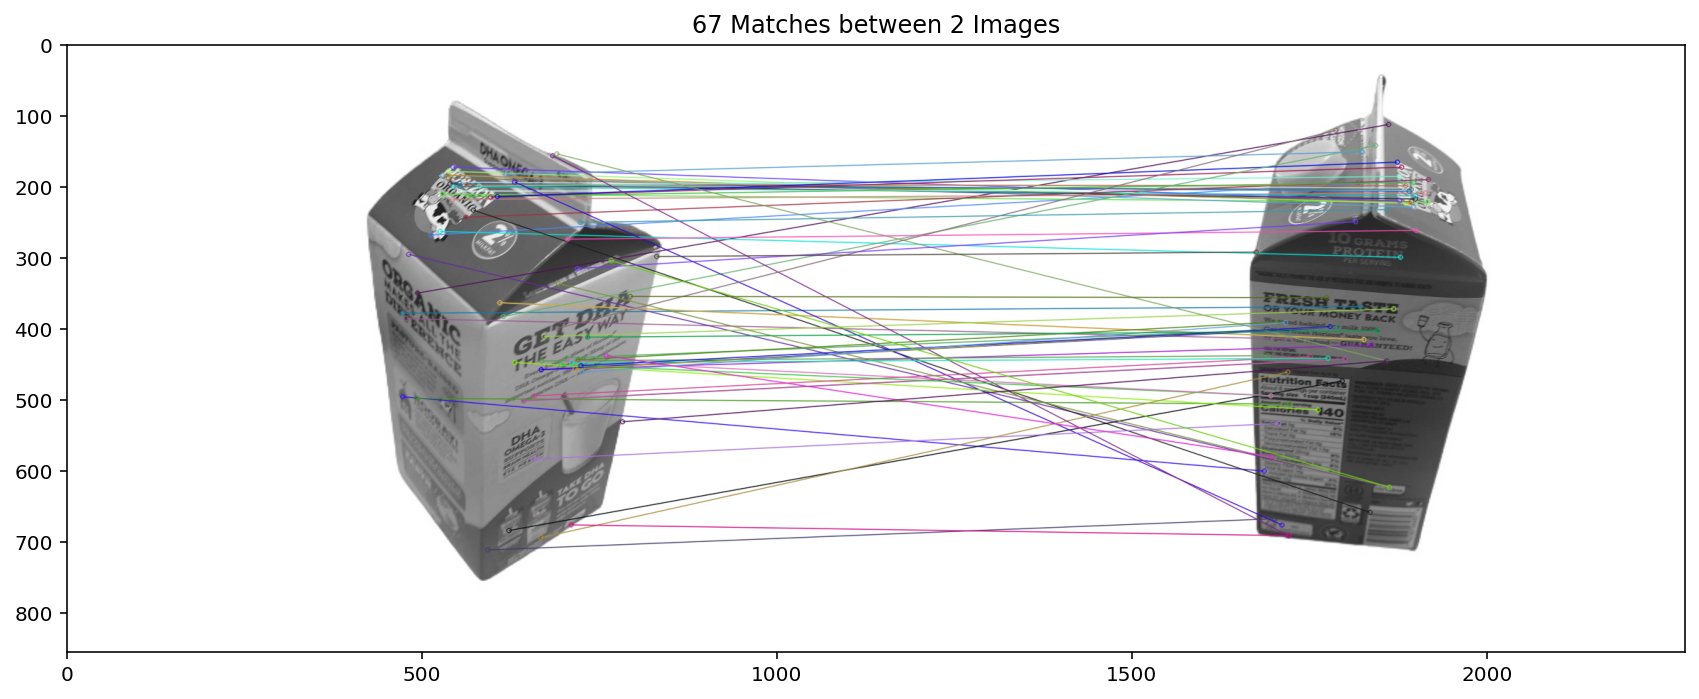

In [10]:
def display_matches(image_pair, point_pair, matches):
    stitch_image = np.empty(
        (max(image_pair[0].shape[0], image_pair[1].shape[0]), image_pair[0].shape[1] + image_pair[1].shape[1], 3),
        dtype=np.uint8
    )

    cv2.drawMatches(image_pair[0], point_pair[0], image_pair[1], point_pair[1], matches, stitch_image, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    plt.figure(figsize=(14.5, 6), dpi=144)
    plt.title('{} Matches between 2 Images'.format(len(matches)))
    plt.imshow(stitch_image)

display_matches(gray_images[:2], feature_points_list[:2], good_matches)


### Superpoints + Superglue

#### Detect Feature Points

In [11]:
import torch
import matplotlib.cm as cm

from thirdparty.SuperPointPretrainedNetwork.superpoint import SuperPoint

In [12]:
superpoint_conf = {
    'descriptor_dim': 256,
    'nms_radius': 3,
    'max_keypoints': 4096,
    'keypoints_threshold': 0.6
}

model = SuperPoint(superpoint_conf)
model.eval()

SuperPoint(
  (relu): ReLU(inplace=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1a): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2a): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4a): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convPa): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convPb): Conv2d(256, 65, kernel_size=(1, 1), stride=(1, 1))
  (convDa): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convDb): Conv2d(25

In [13]:
pretrained_model = torch.load(
    'thirdparty/SuperPointPretrainedNetwork/superpoint_v1.pth',
    map_location='cpu'
)
model.load_state_dict(pretrained_model, strict=True)

<All keys matched successfully>

In [14]:
def normalize_to_tensor(image):
    normalized = image.astype('float32') / 255.
    tensor = torch.from_numpy(normalized).unsqueeze(0).unsqueeze(0)
    return tensor

normalized_gray_images = [normalize_to_tensor(img) for img in gray_images]

print(gray_images[0].shape)
print(normalized_gray_images[0].shape)

(855, 1140)
torch.Size([1, 1, 855, 1140])


In [15]:
predicts = [model(t) for t in normalized_gray_images]

/Users/unbinilium/Documents/Develop/Python/SfM/lib/python3.10/site-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [16]:
keypoints = [p['keypoints'][0].detach().numpy() for p in predicts]
scores = [p['scores'][0].detach().numpy() for p in predicts]

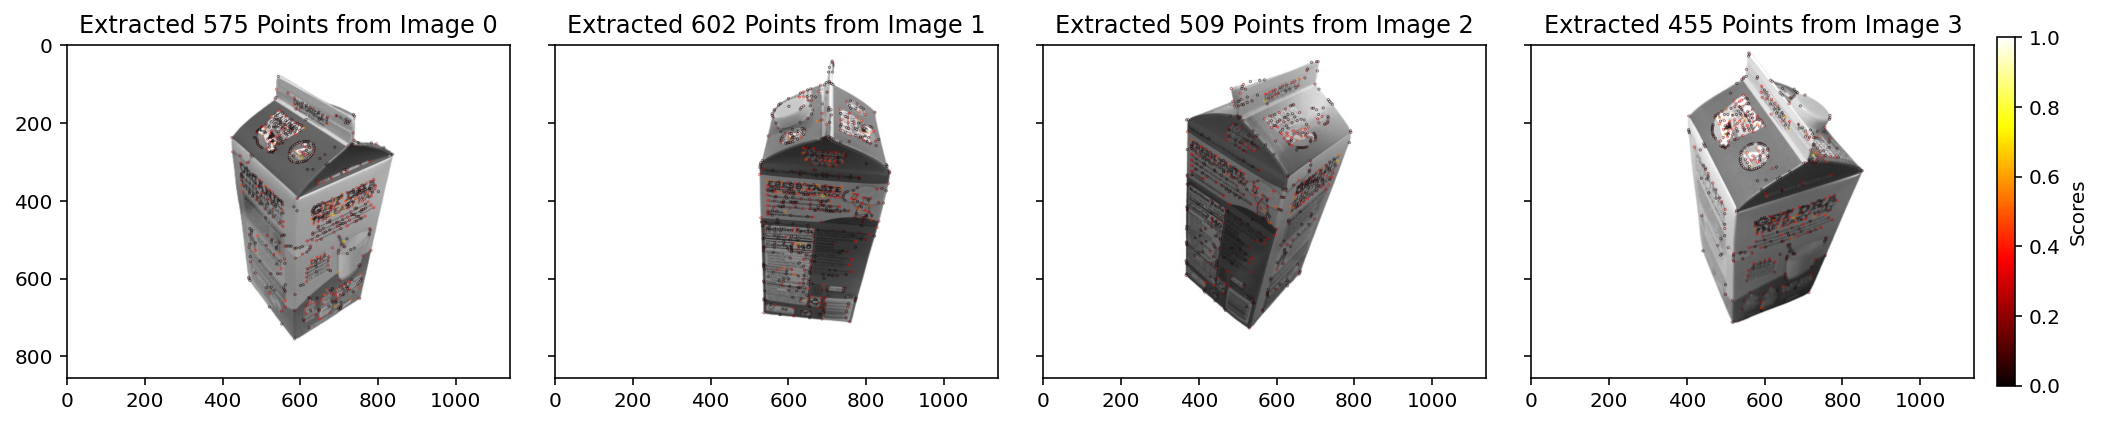

In [17]:
def display_feature_points(images, keypoints, scores):
    fig, ax = plt.subplots(1, len(images), figsize=(16.5, 3), constrained_layout=True, sharey=True)
    fig.set_dpi(144)
    fig.tight_layout()
    fig.colorbar(cm.ScalarMappable(cmap=cm.hot), ax=fig.get_axes(), orientation='vertical', label='Scores', pad=0.01)

    for i in range(0, len(images)):
        out_img = images[i].copy()
        out_img = cv2.cvtColor(out_img, cv2.COLOR_GRAY2RGB)
        kpts = np.round(keypoints[i]).astype(int)
        
        for (x, y), s in zip(kpts, scores[i]):
            color = (np.array(cm.hot(s)) * 255).astype('uint8')
            cv2.circle(out_img, (x, y), 3, color.tolist(), 1, lineType=cv2.LINE_AA)

        ax[i].set_title('Extracted {} Points from Image {}'.format(len(kpts), i))
        ax[i].imshow(out_img)

display_feature_points(gray_images, keypoints, scores)